<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo02_pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-Processamento e limpeza do dataset

### Iniciando pela configuração do Google Colab

In [1]:
# Instalação de libs que não estão presentes no Colab
!pip install -q emoji
!pip install -q transformers --no-cache-dir
!pip install -q sentencepiece

     |████████████████████████████████| 175 kB 5.3 MB/s 
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 70.0 MB/s 
     |████████████████████████████████| 101 kB 57.3 MB/s 
     |████████████████████████████████| 6.6 MB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [2]:
# Configura acesso ao Google Driver onde serão salvos os arquivos grandes
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importação de bibliotecas utilizadas no pré-processamento
import re
import emoji
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from IPython.display import display
%matplotlib inline
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 0)
tqdm.pandas()
# Identifica device gpu ou cpu disponível
device_disponivel = 'cuda' if torch.cuda.is_available() else 'cpu'

### Carregar arquivo CSV das bases unificadas e validar

In [4]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/datasets_unificados.csv', sep = ',', names=['texto', 'classe'], header=1).reset_index(drop=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   9537 non-null   object
 1   classe  9537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.1+ KB


In [ ]:
dados[dados['texto'].str.len()<400].sample(n=5)

,texto,classe
9463,"👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿\n\nProfessor da UFC, Universidade Federal do Ceará, vai para faculdade ministrar sua aula com a camisa do Bolsonaro e é brutalmente espancado e humilhado, chega a ser cuspido por alunos e alunas.\n\n*É esta a esquerda?*\n\n*De quem é mesmo o discurso de ódio?*\n\n*Espalhem maciçamente!* 👇👇👇👇👇",1
7822,"O povo tá tão doido pelo Bolsonaro, que estão seguindo velório achando que é carreata do homem. 😱😂",0
8089,Em resposta ao senhor Haddad que quer saber quem banca a campanha do Jair: Somos marketeiros do Jair Messias Bolsonaro - Somos marketeiros do Jair Messias Bolsonaro - https://secure.avaaz.org/po/petition/Em_resposta_ao_senhor_Haddad_que_quer_saber_quem_banca_a_campanha_do_Jair_Somos_marketeiros_do_Jair_Messias_Bolsonaro/?zEcTznb,1
8206,"Pronto!!!!\n ja cumpri com minha obrigação e agora vou fazer uma promessa, se ele ganhar no primeiro turno nunca mais eu bebo....😳\nForça Eymael\n🍺🍻",0
8787,"Independente em quem vocês irão votar, o *TSE recomenda*:\n\n1. Levar uma colinha de seu candidato no *BOLSO*.\n2. Na zona eleitoral, entrar e *JAIR VOTANDO*.\n3. Não se esqueçam que a votação encerra às *17*.\n\nAnotem as dicas aí😎🇧🇷",0


### Exploração e limpeza de dados

In [5]:
def limpar_textos(texto):
    # Corrige marcadores de nova linha indevidos (textuas e não textuais)
    texto = re.sub(r'(\n|\r)', ' ', texto)
    texto = re.sub('(\n|\r)', '', texto)
    # Remove urls no texto
    texto = re.sub(r'(https|http|ftp)?:\/\/(\w|\.|-|\/|\?|\=|\&|\%)*\b', '', texto)
    # Remove emojis por lib
    texto = emoji.replace_emoji(texto, replace='')
    # Mantem apenas caracteres alfanuméricos com e sem acentuação + pontuação
    texto = re.sub(u'[^a-zA-Z0-9áéíóúÁÉÍÓÚâêîôÂÊÎÔãõÃÕçÇ:\-,." ]', '', texto)
    # Remove reticências e pontuação incorreta
    texto = texto.replace('...', '').replace("..", ".").replace(". .", ".")
    # Remove multiplos caracteres em branco
    texto = re.sub(r'\s+',' ', texto)
    return texto.strip()

dados["texto_processado"] = dados.texto.progress_apply(limpar_textos)

  0%|          | 0/9537 [00:00<?, ?it/s]

In [ ]:
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
display(dados[dados['texto'].str.len()<500].sample(n=5)[['classe', 'texto', 'texto_processado']])

,classe,texto,texto_processado
6360,1,"Assista! Vídeo de Lula dizendo que Nicolás Maduro tem amor pelo seu povo. Lula é um monstro!. Assistam [sem vomitar] o vídeo de Lula apoiando o tirano Nicolás Maduro durante campanha presidencial na Venezuela. Em março de 2015, o fascista Nico...","Assista Vídeo de Lula dizendo que Nicolás Maduro tem amor pelo seu povo. Lula é um monstro. Assistam sem vomitar o vídeo de Lula apoiando o tirano Nicolás Maduro durante campanha presidencial na Venezuela. Em março de 2015, o fascista Nicolás Mad..."
8943,0,"*Pastor discreto:*\n\nQueridos irmãos!\nSomos ensinados a não nos envolvemos com política ou partido, sendo que, devemos exercer nosso compromisso de cidadão, ou seja, votar de acordo a nossa consciência, analisando e escolhendo bem os candidatos...","Pastor discreto: Queridos irmãos Somos ensinados a não nos envolvemos com política ou partido, sendo que, devemos exercer nosso compromisso de cidadão, ou seja, votar de acordo a nossa consciência, analisando e escolhendo bem os candidatos que vã..."
7709,1,"A gang petista acabou de cometer suicídio político! Esse vídeo seria a única coisa que jamais deveriam ter feito, e com certeza o presidiário chefe da gang não foi comunicado. Assistam e passe pra todo mundo;\n👇👇👇👇👇","A gang petista acabou de cometer suicídio político Esse vídeo seria a única coisa que jamais deveriam ter feito, e com certeza o presidiário chefe da gang não foi comunicado. Assistam e passe pra todo mundo"
7584,1,"No Ceará, o Comando Vermelho proibiu propaganda do Bolsonaro nos territórios que ""administra"" \n\nhttps://www.opovo.com.br/jornal/reportagem/2018/08/a-interferencia-das-faccoes-criminosas-no-processo-eleitoral.html\n\n*Porque será???*","No Ceará, o Comando Vermelho proibiu propaganda do Bolsonaro nos territórios que ""administra"" Porque será"
8249,1,"São Paulo. \nEstimativa da Polícia, três milhões de pessoas. \nO maior evento registrado na história da Capital Paulista.","São Paulo. Estimativa da Polícia, três milhões de pessoas. O maior evento registrado na história da Capital Paulista."


### O modelo BERTimbau é sensível ao CASE, precisa ser tratado 

In [11]:
# Remove linhas com mais de 10% de palavras em maiúsculo
antes = dados.shape[0]
dados['qtde_maiusculas'] = dados.texto_processado.apply(
    lambda texto: len(re.findall("[A-Z]+[A-Z]+[A-Z]*[\s]+", texto)))
dados = dados[(dados['qtde_maiusculas'] / dados["qtde_palavras"])<0.1][
          ['classe', 'texto', 'texto_processado', 'qtde_palavras']]
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8339, depois: 8114, removido: 225'

## Confere a distribuição de palavras nas classes

Text(0, 0.5, 'quantidade')

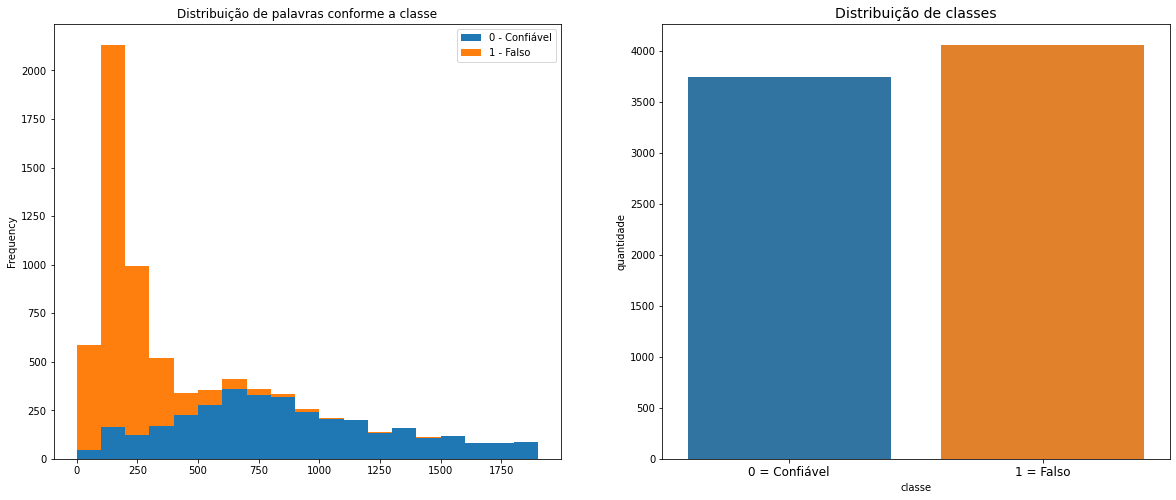

In [14]:
dfplot = dados.pivot(columns='classe').qtde_palavras
dfplot.columns = ['0 - Confiável', '1 - Falso']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes1 = dfplot.plot(
    ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 2000, 100)), 
    title="Distribuição de palavras conforme a classe")
axes2 = sns.countplot(x="classe", data=dados)
axes2.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
axes2.set_title('Distribuição de classes', fontsize=14)
axes2.set_ylabel('quantidade')

In [7]:
antes = dados.shape[0]
dados = dados[dados["qtde_palavras"] >= 50].copy()
display(f"Qtde abaixo de 50 antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde abaixo de 50 antes: 9537, depois: 8460, removido: 1077'

### Remover duplicatas (deveria estar marcado como viral na origem)

In [12]:
# Primeiramente remove duplicatas absolutas do texto
antes = dados.shape[0]
dados = dados.drop_duplicates(subset=['texto_processado'])
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde linhas antes: 8114, depois: 8057, removido: 57'

In [8]:
antes = dados.shape[0]
dados = dados[dados["qtde_palavras"] <= 2500].copy()
display(f"Qtde acima de 2500 antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

'Qtde acima de 2500 antes: 8460, depois: 8339, removido: 121'

In [10]:
display(f"Maximo de palavras: {dados['qtde_palavras'].max()}", f"Mínimo de palavras: {dados['qtde_palavras'].min()}")
display(dados.nsmallest(n=5, columns=['qtde_palavras'])[['texto_processado', 'qtde_palavras']])

'Maximo de palavras: 2495'

'Mínimo de palavras: 50'

,texto_processado,qtde_palavras
5864,"Senador do PT declara: ""Se eles vencerem, vamos para as ruas. Serão dias terríveis"". O senador dava entrevista no salão verde da Câmara e prometia: ""Se eles vencerem, nós vamos nos levantar. Vamos ter profunda instabilidade no Brasil. Os movimentos sociais vão se levantar. Serão dias terríveis"". fonte: O Antagonista",50
7202,"Kkkkkk essa acho que nem o Bolsonaro esperavaEscute só a Música Pró Bolsonaro, que já circula em todo o Planeta gravada por artistas cubanos nos Estados Unidos, está invadindo as rádios do mundo Viva o Mito Bolsonaro 2018 Presidente do Brasil Agora vai bombar no som dos carros e casas.",50
7592,"A carreata de Bolsonaro em João Pessoa foi o maior evento da história política paraibana: 4500 carros, fora as motocicletas e bikes. Entre o pelotão da frente e o pelotão de trás, foram mais de 5 horas de carro passando em fila dupla, nas avenidas da cidade de João Pessoa.",50
7907,"Olha que coisa maravilhosa a parceria proposta por Bolsonaro com Israel, para beneficiar o Nordeste Brasileiro Vamos viralizar esse vídeo até passar por todo o Nordeste . Vamos fazer eles enxergarem que estão sendo manipulados e comprados por quem não querem fazer nada por eles, além de mantê-los na pobreza",50
8803,"Segundo o PT, ele tá perdendo as eleições por causa de: mensalão Petrolão pedaladas da Dilma líderes do partido presos por corrupção candidato poste que ninguém leva a sério sendo comandado por PRESIDIÁRIO . Por gerar 14 milhões de desempregos 62 mil homicídios X gente falando mal do PT no whatsapp",50


### Remover linhas com mais de 50% das palavras iguais, quando menos de 100 palavras.

In [13]:
dados_menos_100_palavras = dados[dados["qtde_palavras"]<100]

# Calcula quantidade de palavras duplicadas
def confere_duplicidade(coluna_busca):
  conjunto_palavras = set(re.findall(r"[\w']+", coluna_busca))
  dados_sem_busca = dados_menos_100_palavras.drop(dados.index[dados['texto_processado'] == coluna_busca])
  dados_sem_busca['duplicado_corrente'] = dados_sem_busca.texto_processado.apply(lambda texto: len(conjunto_palavras.intersection(set(re.findall(r"[\w']+", texto)))))
  return int(dados_sem_busca['duplicado_corrente'].max())

dados['qtde_palavras_duplicadas'] = dados[dados["qtde_palavras"]<100].texto_processado.progress_apply(confere_duplicidade)
dados_menos_100_palavras = pd.DataFrame() #libera área
antes = dados.shape[0]
dados = dados[((dados['qtde_palavras_duplicadas'] / dados["qtde_palavras"])<0.5) | (dados['qtde_palavras_duplicadas'].isnull())].copy()
dados.drop('qtde_palavras_duplicadas', axis=1, inplace=True)
display(f"Qtde linhas antes: {antes}, depois: {dados.shape[0]}, removido: {antes-dados.shape[0]}")

  0%|          | 0/834 [00:00<?, ?it/s]

'Qtde linhas antes: 8057, depois: 7807, removido: 250'

### Carrega o modelo pré-treinado de sumarização

### Principal método que gera os tokens, sumariza e transforma os tokens de volta em palavras

In [15]:
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_pt = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device_disponivel)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/730 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

In [19]:
AJUSTA_ESPACOS = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))
def resumir_textos(texto):
  input_ids = tokenizer(
      [AJUSTA_ESPACOS(texto)],
      return_tensors="pt",
      padding="max_length",
    truncation=True,
    max_length=1536
  )["input_ids"]
  t_tokens = input_ids.to(device_disponivel)
  output_ids = model_pt.generate(
      input_ids=t_tokens,
      max_length=500,
      min_length=300,
      no_repeat_ngram_size=2,
      length_penalty=0.9, 
      num_beams=6
  )[0]

  resumo = tokenizer.decode(
      output_ids,
      skip_special_tokens=True,
      clean_up_tokenization_spaces=False
  )
  return resumo

### Ajustes de uso de memória para garantir que o modelo rode até o final

In [20]:
# Divide o dataframe para executar o modelo somente nos textos grandes e salvar parte do trabalho devido a quedas pela demora
df_menor500, df_maior500 = dados.query('qtde_palavras <= 500').copy(), dados.query('qtde_palavras > 500').copy()

# Salva novamente os dados para uso no notebook do próximo passo.
df_menor500.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_menor500.csv', sep = ',', index=False)
df_maior500.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado_maior500.csv', sep = ',', index=False)

display(f"Menor: {df_menor500.shape[0]}; Maior: {df_maior500.shape[0]}")

'Maior: 4571; Menor: 3236'

In [21]:
# Processa resumos com lib swifter que roda em paralelo
df_maior500["texto_resumido"] = df_maior500['texto_processado'].progress_apply(resumir_textos)
# Atualiza qtde_palavras
df_maior500["qtde_palavras"] = df_maior500.texto_processado.apply(lambda texto: len(re.findall(r"[\w']+", texto)))

  0%|          | 0/3236 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
dados = pd.concat(
    [df_menor500, df_maior500],
    ignore_index=True,
    copy=True,
)

### Plota novamente para ver como ficou

In [ ]:
dfplot = dados.pivot(columns='classe').qtde_palavras
dfplot.columns = ['0 - Confiável', '1 - Falso']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axes1 = dfplot.plot(
    ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 500, 50)), 
    title="Distribuição de palavras conforme a classe")
axes2 = sns.countplot(x="classe", data=dados)
axes2.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
axes2.set_title('Distribuição de classes', fontsize=14)
axes2.set_ylabel('quantidade')


### Salva resultado para usar na exploração

In [ ]:
# Salva novamente os dados para uso no notebook do próximo passo.
dados.to_csv('/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',', index=False)